# Sampling from Light Tail Distribution: Time Step

In this notebook we consider a simple and natural case where the potential has non-Lipschitz gradient.
Our goal is to sample from the density 
\begin{equation*}
\mu^*(x) \propto \exp{\big(-\tfrac{|x|^4}{4} \big)} \, ,
\end{equation*}
which is a~stationary distribution of the process 
\begin{equation*}
\mathrm{d} Y_t = -Y_t^3 \, \mathrm{d} t + \sqrt{2} \, \mathrm{d} B_t \,.
\end{equation*}

We provide the test with respect to time step $\tau$.

Load neccessary libraries.

In [ ]:
import numpy as np
from tqdm import tqdm
import scipy.stats as sp
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import tplquad 
from jupyprint import jupyprint, arraytex
import matplotlib.pyplot as plt

In [ ]:
# PARAMETERS OF THE RUN
initial_sample = 0*np.ones(1000)
d = len(initial_sample)
time_step_vector = np.linspace(1e-5, 1e-1, 5)
sampling = 10**5
n_MC = 3
tune_interval = 10**4
number_of_samples = sampling+tune_interval

For the compuation of the reference values of moments $\mathbb{E} |Y|^2$, $\mathbb{E} |Y|^4$, and $\mathbb{E} |Y|^6$, se the Juputer notebook $\mathtt{reference.ipynb}$. In this notebook, we just assign the computed values.

In [5]:
#reference value 
EX2 = 31.61232243
EX4 = 1000.318801
EX6 = 31684.37599

To simplify code latter, we introduce following functions which return relatice error (RE) and coefficient of variance (CV). 

In [ ]:
# define a potential and its gradient
def potential(x:float) -> float:
    return np.linalg.norm(x)**4/4

def gradient(x:float) -> float:
    return np.linalg.norm(x)**2 * x

def hessian_p(x: float, p:float) -> float:
    return 2 * x * (np.dot(x,p)) + np.linalg.norm(x)**2 * p  # + 1/time_step * p

def comp_moment(samples, power=2):
    norms = np.linalg.norm(samples, axis=1)
    moment = np.mean(norms**power)
    return moment

In [7]:
# # EXPLICIT SCHEME 

explicit_time_step_re = []
explicit_time_step_cv = []

for time_step in time_step_vector:

    moment = []
    # Monte Carlo 

    for i_MC in range(0, n_MC):

        samples_explicit = [initial_sample]

        for _ in tqdm(range(1, number_of_samples)):

            #gradient step
            x = samples_explicit[-1] - time_step * gradient(samples_explicit[-1])  
            
            # adding Gaussian
            x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
            
            # save value
            samples_explicit.append(x)

        samples_explicit = np.array(samples_explicit[tune_interval:])

        moment.append(comp_moment(samples_explicit, 2))
        
    moment = np.array(moment)

    explicit_time_step_re.append(np.abs(np.mean(moment)-EX2)/EX2)
    explicit_time_step_cv.append(np.std(moment)/np.mean(moment))

explicit_time_step_re = np.array(explicit_time_step_re)
explicit_time_step_cv = np.array(explicit_time_step_cv)

print(explicit_time_step_re)
print(explicit_time_step_cv) 

  0%|          | 0/109999 [00:00<?, ?it/s]/var/folders/82/tsl217q50tv6x9csq7yp35c40000gn/T/ipykernel_71569/3854462552.py:18: RuntimeWarning: invalid value encountered in subtract
  x = samples_explicit[-1] - time_step * gradient(samples_explicit[-1])
  0%|          | 0/109999 [00:00<?, ?it/s]/var/folders/82/tsl217q50tv6x9csq7yp35c40000gn/T/ipykernel_71569/2342638949.py:6: RuntimeWarning: overflow encountered in multiply
  return np.linalg.norm(x)**2 * x
100%|██████████| 109999/109999 [00:03<00:00, 29386.42it/s]


[0.00411732        nan        nan        nan        nan]
[0.0041173236863003265, nan, nan, nan, nan]


In [8]:
# EXPLICIT TAMED SCHEME

explicit_tamed_time_step_re = []
explicit_tamed_time_step_cv = []

# Monte Carlo 

for time_step in time_step_vector:

    moment = []

    for i_MC in range(0, n_MC):

        samples_explicit_tamed = [initial_sample]

        for _ in tqdm(range(1, number_of_samples)):

            # gradient tamed step
            x = samples_explicit_tamed[-1] - time_step * gradient(samples_explicit_tamed[-1]) / (1+time_step*np.linalg.norm(gradient(samples_explicit_tamed[-1]))) 
            
            # adding Gaussian
            x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
            # save value
            samples_explicit_tamed.append(x)

        samples_explicit_tamed = np.array(samples_explicit_tamed[tune_interval:])

        moment.append(comp_moment(samples_explicit_tamed, 2))

    moment = np.array(moment)

    explicit_tamed_time_step_re.append(np.abs(np.mean(moment)-EX2)/EX2)
    explicit_tamed_time_step_cv.append(np.std(moment)/np.mean(moment))

explicit_tamed_time_step_re = np.array(explicit_tamed_time_step_re)
explicit_tamed_time_step_cv = np.array(explicit_tamed_time_step_cv)

print(explicit_tamed_time_step_re)
print(explicit_tamed_time_step_cv) 

100%|██████████| 109999/109999 [00:04<00:00, 25950.32it/s]


[1.00488835e-03 1.97027995e+01 7.97846229e+01 1.79556977e+02
 3.18783996e+02]
[0.00421976 0.00127188 0.00203974 0.00247997 0.00257787]


In [9]:
# IPLA

# Monte Carlo 
implicit_time_step_re = []
implicit_time_step_cv = []

for time_step in time_step_vector:

    moment = []

    for i_MC in range(0, n_MC):

        samples_implicit = [initial_sample]

        for _ in tqdm(range(1, number_of_samples)):

            # inexact proximal step 
            x = minimize(
                lambda x: potential(x) + 1/(2*time_step) * np.linalg.norm(x - samples_implicit[-1])**2, 
                jac=lambda x: gradient(x) + 1/time_step * (x - samples_implicit[-1]),
                hessp=lambda x, p: hessian_p(x,p) + 1/time_step * p,
                x0=samples_implicit[-1], 
                method="Newton-CG"
                ).x
            
            # adding Gaussian
            x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
            # save value
            samples_implicit.append(x)

        samples_implicit = np.array(samples_implicit[tune_interval:])

        moment.append(comp_moment(samples_implicit, 2))

    moment = np.array(moment)

    implicit_time_step_re.append(np.abs(np.mean(moment)-EX2)/EX2)
    implicit_time_step_cv.append(np.std(moment)/np.mean(moment))

implicit_time_step_re = np.array(implicit_time_step_re)
implicit_time_step_cv = np.array(implicit_time_step_cv)

print(implicit_time_step_re)
print(implicit_time_step_cv) 

100%|██████████| 109999/109999 [01:04<00:00, 1698.21it/s]


[4.43900266e-04 1.44550819e+00 2.94905832e+00 4.47693105e+00
 6.01793520e+00]
[0.00372899 0.00015241 0.00014656 0.00013851 0.00013629]


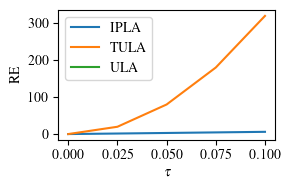

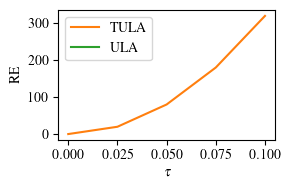

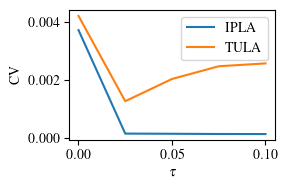

In [13]:
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "text.usetex": True,
    } 
    )

plt.figure(figsize=(3,2))
plt.plot(time_step_vector, implicit_time_step_re, color="C0", label="IPLA")
plt.plot(time_step_vector, explicit_tamed_time_step_re, color="C1", label="TULA")
plt.plot(time_step_vector, explicit_time_step_re, color="C2", label="ULA")
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("RE")
plt.tight_layout()
plt.savefig("time_step_minimizer_re.pdf")

plt.figure(figsize=(3,2))
#plt.plot(time_step_vector[0:5], implicit_time_step_re[0:5], color="C0", label="IPLA")
plt.plot(time_step_vector[0:5], explicit_tamed_time_step_re[0:5], color="C1", label="TULA")
plt.plot(time_step_vector[0:5], explicit_time_step_re[0:5], color="C2", label="ULA")
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("RE")
plt.tight_layout()
plt.savefig("time_step_minimizer_re_detail.pdf")

plt.figure(figsize=(3,2))
plt.plot(time_step_vector, implicit_time_step_cv, color="C0", label="IPLA")
plt.plot(time_step_vector, explicit_tamed_time_step_cv, color="C1", label="TULA")
plt.legend()
plt.xlabel("$\\tau$")
plt.ylabel("CV")
plt.tight_layout()
plt.savefig("time_step_minimizer_cv.pdf")